# Plan of Action

### 1. Ask
    - Define what I am going to do
### 2. Get 
    - Get the data and explore a little bit
### 3. Explore
    - Simple EDA
    - Check for inconsistencies, outliers, etc...
### 4. Prepare
    - Change the data
    - Create dictionary and probabilities 
### 5. Model
    - Create Markov Model
### 6. Results
    - Have fun with weird phrases

# 1. Ask

In this Notebook I'll be attempting to create a simple Markov Chain model to generate headlines. I don't expect it to work properly. Honestly, I am a little bored and wanna see some cool non-sense phrases.

# 2. Get 

- Import modules and data

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import random

data = pd.read_csv('../input/million-headlines/abcnews-date-text.csv')


- Head

In [45]:
data.head()

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers


- Shape

In [46]:
data.shape

(1244184, 2)

# 3. Explore

- NAN

In [47]:
# Check for missing values or na or nan
data.isna().sum()

publish_date     0
headline_text    0
dtype: int64

In [48]:
# Drop nan
data = data.dropna()

- Check types

In [49]:
# Check if all quotes are strings
all(isinstance(headline,str) for headline in data['headline_text'])

True

#### 3.1 Quotes

- Average number of word in quotes

In [50]:
headlines = data['headline_text']

def count_words(sentence: str) -> int:
    return len(sentence.split())

total_num_words = 0
for headline in headlines:
    total_num_words += count_words(str(headline))
    
print(f'Average number of words: {total_num_words/len(headlines)}')


Average number of words: 6.557522842280563


- Dictionary of all words

In [51]:
def clean_word(word: str) -> str:
    word = str(word)
    word = word.lower()
    word = re.sub(r'[^a-zA-Z0-9 ]', '', word)
    return word

In [52]:
import re
word_dict = dict()
for headline in headlines:
    headline = str(headline)
    for word in headline.split():
        word = clean_word(word)
        if word:
            word_dict[word] = word_dict.get(word,0) + 1
            
freq_words = sorted(list(word_dict.items()),key = lambda x: x[1],reverse=True)

for i in range(10):
    k,v = freq_words[i]
    print(k,v)
            
            
    

to 238379
in 156203
for 143278
of 95941
on 82062
the 65067
over 54546
police 39850
at 36895
with 36333


In [97]:
words, freq = zip(*freq_words)
freq = list(freq)
freq

[238379,
 156203,
 143278,
 95941,
 82062,
 65067,
 54546,
 39850,
 36895,
 36333,
 34643,
 33741,
 31176,
 30656,
 30069,
 24333,
 23732,
 23442,
 22931,
 21378,
 20427,
 19153,
 18200,
 18185,
 17131,
 17092,
 16969,
 16788,
 16534,
 15608,
 15595,
 15534,
 13643,
 13468,
 13082,
 13002,
 12859,
 12782,
 12592,
 12477,
 12379,
 11982,
 11930,
 11440,
 11242,
 11199,
 11195,
 10689,
 10636,
 10553,
 10537,
 10392,
 10376,
 10023,
 10006,
 9861,
 9741,
 9674,
 9619,
 9618,
 9612,
 9551,
 9519,
 9479,
 9448,
 9255,
 9211,
 9180,
 9106,
 9097,
 9017,
 8945,
 8886,
 8836,
 8490,
 8488,
 8341,
 8194,
 8172,
 8146,
 8131,
 8127,
 8095,
 8094,
 8061,
 8011,
 7938,
 7915,
 7855,
 7769,
 7744,
 7715,
 7560,
 7519,
 7512,
 7445,
 7422,
 7401,
 7387,
 7349,
 7317,
 7278,
 7273,
 7268,
 7231,
 7225,
 7157,
 7125,
 7089,
 7074,
 7061,
 7003,
 6987,
 6977,
 6970,
 6964,
 6959,
 6910,
 6889,
 6870,
 6850,
 6813,
 6807,
 6720,
 6715,
 6644,
 6626,
 6617,
 6552,
 6532,
 6480,
 6478,
 6471,
 6437,
 642

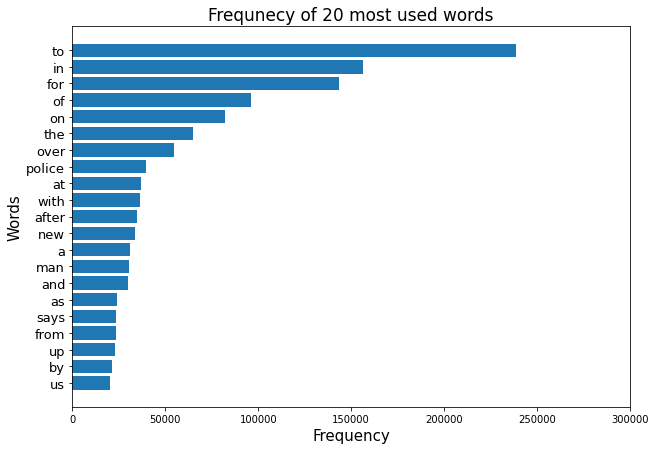

In [140]:
x_axis = words[20::-1]
y_axis = freq[20::-1]

# Figure
plt.figure(figsize = (10,7))

#Labels
plt.title('Frequnecy of 20 most used words',fontsize = 17)
plt.xlabel('Frequency',fontsize = 15)
plt.ylabel('Words',fontsize = 15)

#Ticks
plt.yticks(size = 13)

#Lim
plt.xlim(0,300000)

#Plot
plt.barh(x_axis,y_axis)
plt.show()

Interesting 'Police' is in the top 20....

# 4. Prepare

#### 4.1 Clean text

In order to clean the sentences I am going to do 2 things
- 1. Remove non alpha numeric texts
- 2. Tokenize the words

In [53]:
from typing import List

def clean_text(sentence:str) -> List[str]:
    """Clean_text receives a string (sentence) and 
    returns a list of the words in order but cleaned"""
    
    sentence = str(sentence)
    sentence = sentence.lower() # Lower everything
    sentence = re.sub(r'[^a-zA-Z0-9 ]', '', sentence)  # Remove non-alphanumeric values
    tokens = word_tokenize(sentence) # Tokenize 
    words = [word for word in tokens if word.isalpha()] # Make a list of only accepted words
    return words

#### 4.2 Create cleaned headlines

In [54]:
cleaned_headlines= [clean_text(headline) for headline in headlines]


In [55]:
len(headlines)

1244184

# 5. Model

- Just a useful function

In [56]:
from typing import Dict

def fractionize(d: Dict[str,int]) -> Dict[str,float]:
    """This functions gets all values of a dictionary and 
    make them add up to 1 proportionally"""
    
    sum_of_all_values = sum(d.values())
    return {k:v/sum_of_all_values for k,v in d.items()}   

In [68]:
from typing import List, Dict
from tqdm import tqdm #For a nice visualization :)

def create_Markov_model(sents: List[List[str]], n_gram = 2) -> Dict[str,Dict[str,float]]:
    """A markov model is essentially a graph, and for our purposes, I am going to represent
    it as an adjacency list using nested dictionaries. Exemple: {love: {is:9,more:3}...} means 
    after "love", "is" appears 9 times and "more" appears 3 times"""
    
    markov_model = {}
    
    window_size = 2*n_gram
    # Go through each sentence
    for sent in tqdm(sents):
        for i in range(len(sent)-window_size + 1):
            # Get the words that will be stored in markov_model
            pre, pos = sent[i:i+n_gram],sent[i+n_gram:i+window_size]
            pre, pos = ' '.join(pre),' '.join(pos)
            
            
            # Go on markov_model, get 'pre' (if it doesn't exist then add a dictionary). 
            # Now in the 'pre' dictionary get 'pos', (if it doesn't exist then add a 0) and 
            # add 1 to the count
            
            markov_model[pre] = markov_model.get(pre,{})
            markov_model[pre][pos] = markov_model[pre].get(pos,0) + 1
            
    # Make the values of each 'inside' dictionary add up to 1 proportionally        
    for k,v in markov_model.items():
        markov_model[k] = fractionize(markov_model[k])
        
    return markov_model


In [58]:
def make_walk(markov_model:Dict[str,Dict[str,float]],
              start: str = '',
              limit: int = 100,
              random_start: bool = False) -> str:
    """This function generates the sentences by making random walks in the markov model"""
    
    curr_word = start
    if random_start:
        curr_word = random.choice(list(markov_model.keys()))
    
    story = curr_word
    
    n = 0
    while n<limit:
        
        if curr_word not in markov_model:
            break
        word_dict = markov_model[curr_word]
        next_word = random.choices(list(word_dict.keys()),
                                  list(word_dict.values()))
        
        story += " {}".format(next_word[0])
        curr_word = next_word[0]
        n += 1
        
    return story

In [69]:
headlines_markov_model = create_Markov_model(cleaned_headlines,n_gram = 2)

100%|██████████| 1244184/1244184 [00:11<00:00, 107965.57it/s]


# 6.Results

In [148]:
for _ in range(10):
    headline = make_walk(headlines_markov_model,start = 'the critics',limit = 7)
    print(headline)

the critics are saying there are no excuses for wifes forgiveness in collins eulogy
the critics are saying there are no jobs but keep draft picks young talent in the
the critics are saying there are more flint
the critics are saying there are concerns about branxton housing
the critics are saying there are plenty of punches in fight house fires without
the critics are saying is give war a real page
the critics are saying there are fears putin will play it open to nsw police cadets
the critics are saying about the delays in disaster assistance has been caught up in cfk
the critics are saying is give war a decade on queanbeyan still left with only two
the critics are saying there are no easy solution to mountains of dumped car not linked


So, definitively is does not work properly. But it is indeed interesting to see that such a simple model is capable to produce (not always) grammaticaly correct sentences.